In [1]:
import qutip
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy.fft import *
import numpy.linalg as nplin


# QuTiP Algorithm 

In [2]:
# Function Definitions

def coef_z(t, args):
    c_coeff_arr = args['c_coeff']
    #print(c_coeff_arr)
    omega = args['omega']
    N_max = args['Nmax']
    tsize = args['tsize']
    qJ = args['qJ']
    freq = args['freq']
    
    c_result = np.sum(c_coeff_arr*np.exp((2*np.pi*1j*freq*t)))*1/tsize
        

    
    return qJ*c_result

    
def coef_x(t, args):
    #c_coeff_arr = args['c_coeff'][0]
    omega = args['omega'] 
    #N_max = args['Nmax']
    
    Bx = args['Bx']

    return Bx*np.cos(omega*t)


def check_c_same(c_coeff_prev, c_coeff_now, tol=1e-4): # This is to check if the prev and present c_coeff is the same or not
    return np.all(np.abs(c_coeff_now - c_coeff_prev) < tol)

def check_quasi_same(quasi_prev, quasi_now, tol=1e-4):
    if(np.abs(quasi_now-quasi_prev)<1e-4):
        return True
    else:
        return False
    
def check_mz_time_same(mz_prev, mz_now, tol=1e-4):
    
    return np.all(np.abs(np.array(mz_now) - np.array(mz_prev))<tol)
    
def mz_expect(f_modes_table_t, tlist):
    mz_time = []
    for i in range(len(tlist)):
        a = f_modes_table_t[i][0][0]
        b = f_modes_table_t[i][0][1]
        mz_temp = (a.conj()*a-b.conj()*b)[0][0].real
        mz_time.append(mz_temp)
        
    return mz_time


def mz_time(c_coeff, time, N_max, omega):

    mz_arr = []

    c_coeff = c_coeff.flatten(order='C')

    for t in time:
        result = 0
        for i in range(len(c_coeff)):
    
          result += c_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))

 
        mz_arr.append(result)

    return mz_arr


def create_cdft_init(N_max, omega, tlist):
    
    col_size = 2*(2*N_max + 1)

    c_array_init = np.zeros((1,int(col_size/2)),dtype=np.complex_)
    count = 2
    
    
    for i in range(int(col_size/2)):

        if(i == N_max):
            #c_array_init[0,i] = complex(np.random.uniform(low=-1, high=1),0)
            c_array_init[0,i] = 1
        elif(i > N_max):
            #c_array_init[0,i] = np.conj(c_array_init[0,i-count])
            c_array_init[0,i] = 0
            count += 2
        else:
            #c_array_init[0,i] = complex(np.random.uniform(low=-1, high=1), np.random.uniform(low=-1, high=1))
            c_array_init[0,i] = 0
            
    temp = mz_time(c_array_init, tlist, N_max, omega)
    #plt.plot(tlist, temp)
    
    #cdft_init = fft(np.sin(omega*tlist)+np.cos(omega*tlist))
    cdft_init = fft(temp)
    return cdft_init





In [21]:
# All the needed variables
N_max = 60
c_coeff_arr = [] 
quasi_arr = []
total_mz_arr_A = []
total_mx_arr_A = []


omega_arr = [20]
h_bar = 1
qJ = 2


H0 = 2 * np.pi * 0 * sigmaz()
Hx = sigmax()
Hz = sigmaz()
 




for omega in omega_arr:
    Bx_arr = np.arange(0.1, 12.1, 0.1)
    mz_avg_arr = []
    mx_avg_arr = []
    T = 2*np.pi/omega
    tstep = 0.01
    tlist = np.arange(0, T, tstep)
    tsize = tlist.size
    N_max = 60
    freq = np.fft.fftfreq(tsize, d=tstep)
    print("THIS IS THE OMEGA VALUE:", omega)
    
    c_array_init = create_cdft_init(N_max, omega, tlist)
    c_coeff_prev = c_array_init
    for Bx in Bx_arr:
        
        print("This is Bx:", Bx)
        
        counter = 0
        condition_c_coeff = False
        condition_quasi = False 
        
        c_coeff_now = c_coeff_prev
        
        quasi_now = 0
        
        args={'c_coeff':c_coeff_prev,'omega':omega, 'Nmax':N_max, 'qJ': qJ, 'Bx':Bx, 'tsize':tsize, 'freq': freq}
        H=[H0,[Hx,coef_x], [Hz, coef_z]]
        
        f_modes_0, f_energies = floquet_modes(H, T, args, sort = True, options=Options(nsteps=1000))
        f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, args)
        mz_prev = mz_expect(f_modes_table_t, tlist)
        
        #while( (((condition_quasi == False) or (condition_c_coeff == False)) and counter < 10000)):
        while( (((condition_quasi == False) or (condition_mz_time == False)) and counter < 10000)):
            
            # Saving to the previous one
            quasi_prev = quasi_now 
            ##c_coeff_prev = c_coeff_now

            # Building the new Hamiltonian
            args={'c_coeff':c_coeff_prev,'omega':omega, 'Nmax':N_max, 'qJ': qJ, 'Bx':Bx, 'tsize':tsize, 'freq': freq}
            H=[H0,[Hx,coef_x], [Hz, coef_z]]
            #print("HELLO")
            f_modes_0, f_energies = floquet_modes(H, T, args, sort = True, options=Options(nsteps=10000))

            # Obtaining the new values
            quasi_now = f_energies[0]
            f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, args)
            mz_now = mz_expect(f_modes_table_t, tlist)
            c_coeff_now = fft(mz_now)
            
            condition_c_coeff = check_c_same(c_coeff_prev, c_coeff_now)
            condition_quasi = check_quasi_same(quasi_prev, quasi_now)
            condition_mz_time = check_mz_time_same(mz_prev, mz_now)
            
            c_coeff_now = c_coeff_now*0.6+ c_coeff_prev*(0.4)
            c_coeff_prev = c_coeff_now 
            mz_prev = mz_now
            
#             condition_c_coeff = check_c_same(c_coeff_prev, c_coeff_now)
#             condition_quasi = check_quasi_same(quasi_prev, quasi_now)

            counter += 1
#             print("This is the counter:", counter)
#             print("This is c_coeff condition", condition_c_coeff)
#             print("This is quasi condition", condition_quasi)
#             print("This is c array: ")
#             print(f_modes_0[0])
#             print()
            
            

            
              
            
        mz_time_val = mz_expect(f_modes_table_t, tlist)
        mz_avg = np.absolute(np.average(mz_time_val))
        mz_avg_arr.append(mz_avg)
              
    
    total_mz_arr_A.append(mz_avg_arr)
    
    
    

THIS IS THE OMEGA VALUE: 4
This is Bx: 0.1
This is Bx: 0.2
This is Bx: 0.30000000000000004
This is Bx: 0.4
This is Bx: 0.5
This is Bx: 0.6
This is Bx: 0.7000000000000001
This is Bx: 0.8
This is Bx: 0.9
This is Bx: 1.0
This is Bx: 1.1
This is Bx: 1.2000000000000002
This is Bx: 1.3000000000000003
This is Bx: 1.4000000000000001
This is Bx: 1.5000000000000002
This is Bx: 1.6
This is Bx: 1.7000000000000002
This is Bx: 1.8000000000000003
This is Bx: 1.9000000000000001
This is Bx: 2.0
This is Bx: 2.1
This is Bx: 2.2
This is Bx: 2.3000000000000003
This is Bx: 2.4000000000000004
This is Bx: 2.5000000000000004
This is Bx: 2.6
This is Bx: 2.7
This is Bx: 2.8000000000000003
This is Bx: 2.9000000000000004
This is Bx: 3.0000000000000004
This is Bx: 3.1
This is Bx: 3.2
This is Bx: 3.3000000000000003
This is Bx: 3.4000000000000004
This is Bx: 3.5000000000000004
This is Bx: 3.6
This is Bx: 3.7
This is Bx: 3.8000000000000003
This is Bx: 3.9000000000000004
This is Bx: 4.0
This is Bx: 4.1
This is Bx: 4.2


# Old Algorithm

In [4]:
def find_eigenvalues(H_floquet, omega):

    eigenvals, eigenvects = nplin.eig(H_floquet)
    eigenvals = eigenvals.real

    abs_eigenvals = np.abs(eigenvals)
    min_eigenvalue = '%.3f'%np.amin(abs_eigenvals)
    bounded_eigenvals = []
    index_eigenvals = []

    for i in range(len(eigenvals)):
        i_eigenval = '%.3f'%(eigenvals[i])


    if (i_eigenval == min_eigenvalue):

        bounded_eigenvals.append(eigenvals[i])
        index_eigenvals.append(i)

    max_eigenvalue = bounded_eigenvals[0]
  
    max_eigenvector = eigenvects[:,index_eigenvals[0]]


    for i in range(len(max_eigenvector)):
        if np.abs(max_eigenvector[i])< 10**(-4):
            max_eigenvector[i] = 0

    return max_eigenvalue, max_eigenvector


def find_fourier_coeff(eigenvector, N_max):
    a_coeff = np.array([], dtype = np.complex_)
    b_coeff = np.array([], dtype = np.complex_)
    c_coeff = np.array([], dtype = np.complex_) # This array is in terms of the a's and b's coefficients

  # Finding the a's and b's coefficients first for the Floquet Modes
    for i in range(len(eigenvector)):
        if (i%2 == 0):
            a_coeff = np.append(a_coeff, eigenvector[i])
        elif(i%2 != 0):
            b_coeff = np.append(b_coeff, eigenvector[i])


    for l in range(N_max, -N_max-1, -1):
        temp = 0
        for m in range(N_max, -N_max-1, -1): # For Loop for the conjugated one
            for n in range(N_max, -N_max-1, -1): #For Loop for the non-conjugated one
                if(-m+n == l):
        
                    temp += (a_coeff[N_max-m].conj()*a_coeff[N_max-n] - b_coeff[N_max-m].conj()*b_coeff[N_max-n])
      
        if np.abs(temp) < 10**(-4):
            temp = 0
            c_coeff = np.append(c_coeff, temp)
        else:
            c_coeff = np.append(c_coeff, temp)
 


    return a_coeff, b_coeff, c_coeff


def mz_time(c_coeff, time, N_max, omega):

    mz_arr = []

    c_coeff = c_coeff.flatten(order='C')

    for t in time:
        result = 0
        for i in range(len(c_coeff)):
              result += c_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
 
        mz_arr.append(result)

    return mz_arr
  

def mx_time(a_coeff, b_coeff, time, N_max, omega):
    mx_arr = []
    
    for t in time:
        result_a = 0
        result_b = 0
        result_a_conj = 0
        result_b_conj = 0
        total_result = 0

    for i in range(len(a_coeff)):
        result_a += a_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
        result_b += b_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
        result_a_conj += a_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))
        result_b_conj += b_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))
      
    
    total_result += ((result_a_conj*result_b) + (result_b_conj*result_a))
    mx_arr.append(total_result)

    return mx_arr


def my_time(a_coeff, b_coeff, time, N_max, omega):
    my_arr = []

    for t in time:
        result_a = 0
        result_b = 0
        result_a_conj = 0
        result_b_conj = 0
        total_result = 0

        for i in range(len(a_coeff)):
            result_a += a_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
            result_b += b_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
            result_a_conj += a_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))
            result_b_conj += b_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))
      
    
        total_result += ((result_a_conj*complex(0,-1)*result_b) + (result_b_conj*complex(0,1)*result_a))
        my_arr.append(total_result)

    return my_arr



def floquet_hamiltonian(c_array, N_max, Bx, qJ): # Creating the Floquet Hamiltonian Matrix

    c_array = np.array(c_array) # Assigning the initial array
    H_floquet = np.zeros((1, col_size), dtype=np.complex_)
    count_row = 0


    for i in range(N_max, -N_max-1,-1): # This the i in j+k, and j+k has to equal to i

    # For the a coefficients first
    
        temp_row_a = np.zeros((col_size), dtype = np.complex_) # to store the a's and b's
        temp_row_b = np.zeros((col_size), dtype = np.complex_) # Ini bentuknya itu kaya [0,0,0,0,0,...,0] bukan [[0,0,0,0,...,0]]
        count_1 = 0
        for j in range(N_max, -N_max-1, -1): # This is looping for the coefficients in a
            for k in range(N_max, -N_max-1, -1): # This is looping for the coefficients in c
                if j+k == i:

                    if(j == i):
                        temp_row_a[N_max-j+count_1] = qJ*c_array[0, N_max-k]+(i*h_bar*omega)
                        temp_row_b[N_max-j+count_1+1] = -1*qJ*c_array[0, N_max-k]+(i*h_bar*omega)
                    else:
                        temp_row_a[N_max-j+count_1] = qJ*c_array[0, N_max-k]
                        temp_row_b[N_max-j+count_1+1] = -1*qJ*c_array[0, N_max-k]

            count_1 += 1
    

        count_2 = 1
        for j in range(N_max, -N_max-1,-1): # This is looping for the coefficients in b but in the same temp_row

            if(np.abs(j-i) == 1):

                temp_row_a[N_max-j+count_2] = Bx
                temp_row_b[N_max-j+count_2-1] = Bx

            count_2 += 1

        H_floquet = np.vstack([H_floquet, temp_row_a])
        H_floquet = np.vstack([H_floquet, temp_row_b])

    H_floquet = H_floquet[1:]

    return H_floquet
 

def check_symmetric(a, tol=1e-4): # Check whether the Hamiltonian is a hermitian or not
    return np.all(np.abs(a-a.conj().T) < tol)

def check_c_same(c_coeff_prev, c_coeff_now, tol=1e-4): # This is to check if the prev and present c_coeff is the same or not
    return np.all(np.abs(c_coeff_now - c_coeff_prev) < tol)



In [70]:
# Some variables
N_max = 60
c_coeff_arr = [] 
iter_arr = []
quasi_arr = []

qJ = 2
omega_arr = [20]
h_bar = 1

period = (2*np.pi)/omega

mx_avg_arr = []
my_avg_arr = []
mz_avg_arr = []

total_mx_arr = []
total_my_arr = []
total_mz_arr = []

total_mx_time = []
total_my_time = []
total_mz_time = []

[Bx_mesh, omega_mesh] = np.meshgrid(Bx_arr, omega_arr)

for omega in omega_arr:
    print("THIS IS THE OMEGA VALUE:", omega)
    Bx_arr = np.arange(0.1, 12.3, 0.2)
    h_bar = 1
    period = (2*np.pi)/omega
    mz_avg_arr = []
    mx_avg_arr = []
    
    
    row_size = 2*(2*N_max + 1)
    col_size = 2*(2*N_max + 1)
    c_array_init = np.zeros((1,int(col_size/2)),dtype=np.complex_)
    for i in range(int(col_size/2)):

        if(i == N_max):
            c_array_init[0,i] = complex(1,0)
        elif(i > N_max):
            c_array_init[0,i] = np.conj(c_array_init[0,i-count])
            count += 2
        else:
            c_array_init[0,i] = complex(0, 0)
        
        
    for Bx in Bx_arr:
        Bx = float('%.1f'%(Bx))
        print("This is this Bx:", Bx)



        c_prev = np.copy(c_array_init)

        H_floquet = floquet_hamiltonian(c_prev, N_max, Bx, qJ)

        condition_hermit = False
        condition_c_coeff = False


        counter = 0 # To count the number of iteration

        quasienergy_prev = 0
        quasienergy_new = 1

    

        while( ((condition_hermit == False) or (np.abs(quasienergy_prev-quasienergy_new) > 1e-4) or (condition_c_coeff == False)) and counter < 10000):

            quasienergy_prev = quasienergy_new

            c_prev = np.copy(c_array_init)
            H_floquet = floquet_hamiltonian(c_array_init, N_max, Bx, qJ)
            max_eigenvalue, max_eigenvector= find_eigenvalues(H_floquet, omega)
    


            quasienergy_new = max_eigenvalue

            quasi_arr.append(quasienergy_new)



            ## Finding the c coefficients for m_z(t) ##
            a_coeff, b_coeff, c_coeff = find_fourier_coeff(max_eigenvector, N_max)


            c_array_init = np.array([c_coeff])*0.68+ c_prev*(0.32) # Generating the new guess for the next iteration


            H_floquet = floquet_hamiltonian(c_array_init, N_max, Bx, qJ)

            condition_hermit = check_symmetric(H_floquet)
            condition_c_coeff = check_c_same(c_prev, c_array_init)


            iter_arr.append(counter)
            counter += 1



    
        c_coeff_arr.append(c_array_init)

        time_arr = np.arange(0,period, 0.001)

        mz = mz_time(c_array_init, time_arr, N_max, omega)
        mz_avg = np.average(mz)
        mz_avg_arr.append(mz_avg)
        total_mz_time_old_A_20.append(mz)

        mx = mx_time(a_coeff, b_coeff, time_arr, N_max, omega)
        mx_avg = np.average(mx)
        mx_avg_arr.append(mx_avg)
        total_mx_time_old_A_20.append(mx)

    
    
    total_mz_arr.append(mz_avg_arr)
    print("This", omega, "is added to the total_mz_arr array")
    total_mx_arr.append(mx_avg_arr)
    print("This", omega, "is added to the total_mx_arr array")
    print("\n")





THIS IS THE OMEGA VALUE: 20
This is this Bx: 0.1
This is this Bx: 0.3
This is this Bx: 0.5
This is this Bx: 0.7
This is this Bx: 0.9
This is this Bx: 1.1
This is this Bx: 1.3
This is this Bx: 1.5
This is this Bx: 1.7
This is this Bx: 1.9
This is this Bx: 2.1
This is this Bx: 2.3
This is this Bx: 2.5
This is this Bx: 2.7
This is this Bx: 2.9
This is this Bx: 3.1
This is this Bx: 3.3
This is this Bx: 3.5
This is this Bx: 3.7
This is this Bx: 3.9
This is this Bx: 4.1
This is this Bx: 4.3
This is this Bx: 4.5
This is this Bx: 4.7
This is this Bx: 4.9
This is this Bx: 5.1
This is this Bx: 5.3
This is this Bx: 5.5
This is this Bx: 5.7
This is this Bx: 5.9
This is this Bx: 6.1
This is this Bx: 6.3
This is this Bx: 6.5
This is this Bx: 6.7
This is this Bx: 6.9
This is this Bx: 7.1
This is this Bx: 7.3
This is this Bx: 7.5
This is this Bx: 7.7
This is this Bx: 7.9
This is this Bx: 8.1
This is this Bx: 8.3
This is this Bx: 8.5
This is this Bx: 8.7
This is this Bx: 8.9
This is this Bx: 9.1
This i

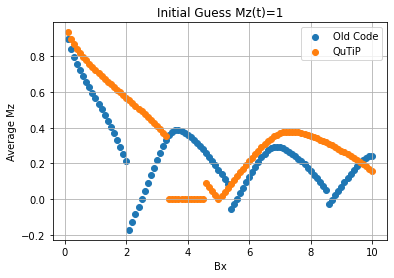

In [40]:
Bx_arr_12 = np.arange(0.1, 10.1, 0.1)
plt.scatter(Bx_arr_12,(total_mz_arr_1[0]), label="Old Code")
plt.scatter(Bx_arr_12, total_mz_arr_2[0], label="QuTiP")
plt.legend(loc="upper right")
plt.title("Initial Guess Mz(t)=1")
plt.xlabel("Bx")
plt.ylabel("Average Mz")
plt.grid()
plt.show()

/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


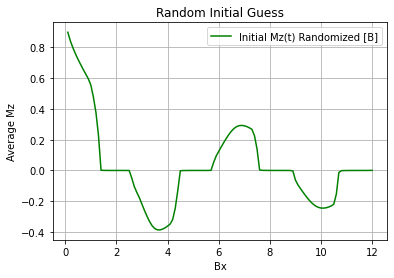

In [67]:
## Category A: Using the previous convergence result
#plt.plot(Bx_arr_old, (total_mz_arr_old_A[0]), label="Initial Mz(t)=1 [A]")
#plt.plot(Bx_arr_12, total_mz_arr_1[0], label="Initial Mz(t)=1 [B]", color="orange")
plt.plot(Bx_arr_old, (total_mz_arr_old_B_1[0]), label="Initial Mz(t) Randomized [B]", color="green")
#plt.scatter(Bx_arr_old, total_mz_arr_A[0], label="QuTiP")
plt.legend(loc="upper right")
plt.title("Random Initial Guess")
plt.xlabel("Bx")
plt.ylabel("Average Mz")
plt.grid()
plt.show()

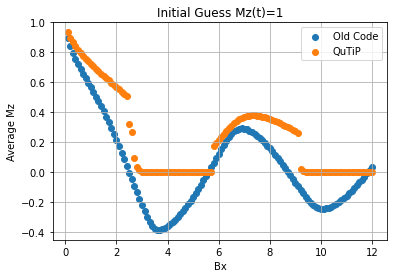

In [42]:
plt.scatter(Bx_arr_old, (total_mz_arr_old_A_1[0]), label="Old Code")
plt.scatter(Bx_arr_old, total_mz_arr_A[0], label="QuTiP")
plt.legend(loc="upper right")
plt.title("Initial Guess Mz(t)=1")
plt.xlabel("Bx")
plt.ylabel("Average Mz")
plt.grid()
plt.show()

/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


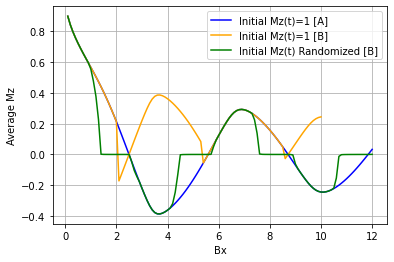

In [63]:
plt.plot(Bx_arr_old, (total_mz_arr_old_A[0]), label="Initial Mz(t)=1 [A]", color="blue")
plt.plot(Bx_arr_12, total_mz_arr_1[0], label="Initial Mz(t)=1 [B]", color="orange")
plt.plot(Bx_arr_old, (total_mz_arr_old_B_1[0]), label="Initial Mz(t) Randomized [B]", color="green")
#plt.scatter(Bx_arr_old, total_mz_arr_A[0], label="QuTiP")
plt.legend(loc="upper right")
#plt.title("Initial Guess Mz(t)=1")
plt.xlabel("Bx")
plt.ylabel("Average Mz")
plt.grid()
plt.show()

In [77]:
plt.plot(Bx_arr_old, total_mz_arr_old_A_20[0])
plt.grid()
plt.ylabel("Average Mz")
plt.xlabel("Bx")

/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Bx')

In [76]:
%matplotlib

for i in range(len(Bx_arr_old)):
    plt.cla()
    plt.ylim(-1.5, 1.5)
    plt.title('%.1f'%(Bx_arr_old[i]))
    plt.plot(time_arr, total_mz_time_old_A_20[i], color="blue")
    #plt.plot(time_arr, total_mx_time_old_A_20[i], color="orange")
    #plt.plot(time_arr, total_my_time_old_A_20[i], color="green")
    plt.xlabel("Time (t)") 
    plt.ylabel("Mz(blue), Mx (orange), My (red) ")
    plt.grid()
    plt.pause(0.5)
    plt.show()

Using matplotlib backend: MacOSX


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


# OLD VS NEW ALGORITHM (MUCH NEATER VERSION)

## The QuTiP Version

In [2]:
def coef_z(t, args):
    c_coeff_arr = args['c_coeff']
    omega = args['omega']
    N_max = args['Nmax']
    tsize = args['tsize']
    qJ = args['qJ']
    freq = args['freq']
    
    c_result = np.sum(c_coeff_arr*np.exp((2*np.pi*1j*freq*t)))*1/tsize
        
    return qJ*c_result
  
    
def coef_x(t, args): # This is the oscillating field term
    
    omega = args['omega'] 
    Bx = args['Bx']

    return Bx*np.cos(omega*t)


def mz_expect(f_modes_table_t, tlist):
    mz_time = []
    for i in range(len(tlist)):
        a = f_modes_table_t[i][0][0]
        b = f_modes_table_t[i][0][1]
        mz_temp = (a.conj()*a-b.conj()*b)[0][0].real
        mz_time.append(mz_temp)
        
    return mz_time


def mx_expect(f_modes_table_t, tlist):
    mx_time = []
    for i in range(len(tlist)):
        a = f_modes_table_t[i][0][0]
        b = f_modes_table_t[i][0][1]
        mx_temp = (a.conj()*b+b.conj()*a)[0][0].real
        mx_time.append(mx_temp)
        
    return mx_time


def my_expect(f_modes_table_t, tlist):
    my_time = []
    for i in range(len(tlist)):
        a = f_modes_table_t[i][0][0]
        b = f_modes_table_t[i][0][1]
        my_temp = (a.conj()*-1j*b+b.conj()*1j*a)[0][0].real
        my_time.append(my_temp)
        
    return my_time


def energy_expect(f_modes_table_t, mz_expect, qJ, omega, Bx, tlist):
    
    energy_time=[]
    for i in range(len(tlist)):
        hamiltonian_matrix = np.array([[qJ*mz_expect[i], Bx*np.cos(omega*tlist[i])],
                                       [Bx*np.cos(omega*tlist[i]), -qJ*mz_expect[i]]])
        
        a = f_modes_table_t[i][0][0] 
        b = f_modes_table_t[i][0][1]
        vector = np.array([a[0][0], b[0][0]])
        first_mul = hamiltonian_matrix @ vector
        second_mul = np.matmul(np.conjugate(vector),first_mul)
        energy_time.append(second_mul)
    
    return energy_time 


def mz_time(c_coeff, time, N_max, omega):

    mz_arr = []

    c_coeff = c_coeff.flatten(order='C')

    for t in time:
        result = 0
        for i in range(len(c_coeff)):
        
          result += c_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
 
        mz_arr.append(result)

    return mz_arr


    

def create_cdft_init(N_max, omega, tlist): # Creating the initial DFT coefficient guess
    
    col_size = 2*(2*N_max + 1)

    c_array_init = np.zeros((1,int(col_size/2)),dtype=np.complex_)
    count = 2
    
    for i in range(int(col_size/2)):

        if(i == N_max):
            c_array_init[0,i] = 1
        elif(i > N_max):
            c_array_init[0,i] = 0
            count += 2
        else:
            c_array_init[0,i] = 0

            
    temp = mz_time(c_array_init, tlist, N_max, omega) # mz_time is used here
    cdft_init = fft(temp)
    return cdft_init


def check_c_same(c_coeff_prev, c_coeff_now, tol=1e-4): # This is to check if the prev and present c_coeff is the same or not
    return np.all(np.abs(c_coeff_now - c_coeff_prev) < tol)


def check_quasi_same(quasi_prev, quasi_now, tol=1e-6):
    if(np.abs(quasi_now-quasi_prev)<1e-6):
        return True
    else:
        return False
    
    
def check_mz_time_same(mz_prev, mz_now, tol=1e-4):
    
    return np.all(np.abs(np.array(mz_now) - np.array(mz_prev))<tol)


In [16]:
## Some Variables ## 
N_max = 60

total_mz_arr = []
total_mx_arr = []
total_my_arr = []
total_energy_arr = []

c_coeff_arr = []

mz_time_arr = []
mx_time_arr = []
my_time_arr = []


omega_arr = [4]
h_bar = 1 # Here, we set the planck constant to be 1
qJ = 2


H0 = 2 * np.pi * 0 * sigmaz()
Hx = sigmax() # The Pauli matrix for the spin in the x direction
Hz = sigmaz() # The Pauli matrix for the spin in the z direction
 


for omega in omega_arr: # Looping through different omegas
    
    print("The current omega value:", omega)
    
    ## Some empty arrays ##
    mz_avg_arr = [] # Storing the average expectation value of Mz of different omegas
    mx_avg_arr = [] # Storing the average expectation value of Mx of different omegas
    my_avg_arr = [] # Storing the average expectation value of My of different omegas
    energy_avg_arr = [] # Storing the average expectation value of the Hamiltonian of different omegas
    
    ## Important variables ##
    T = 2*np.pi/omega # The period of the oscillating field
    tstep = 0.01  # The stepping between each point in time
    tlist = np.arange(0, T, tstep)
    tsize = tlist.size # The size of tlist array
    N_max = 60 # The number of DFT/FFT coefficient present
    freq = np.fft.fftfreq(tsize, d=tstep) # the DFT sample frequencies
    
    ## Initializing the initial guess ## 
    c_array_init = create_cdft_init(N_max, omega, tlist) # Calling the initial guess function
    c_coeff_prev = c_array_init # A local variable inside the for loop ??
    

    Bx_arr = np.arange(0.1, 15.2, 0.1) # The Bx that we are going to use
    

    for Bx in Bx_arr: # Looping through different Bx values
        
        counter = 0 # Counting the number of times the iteration has passed (max is 10000) 
        
        ## The initial status of the converging conditions ##
        condition_c_coeff = False 
        condition_quasi = False 
        condition_mz_time = False
        
        ## Setting the initial values for different variables ##
        c_coeff_now = c_coeff_prev
        c_coeff_arr.append(c_coeff_now)
        quasi_now = 0
        mz_prev = -999 # Just setting some random large values for the previous Mz
        mz_now = 999
        mx_now = None 
        my_now = None

        
        
        while( (((condition_quasi == False) or (condition_mz_time == False)) and counter < 10000)):

            # Saving to the previous one
            quasi_prev = quasi_now 
            
            # Building the new Hamiltonian
            args={'c_coeff':c_coeff_prev,'omega':omega, 'Nmax':N_max, 'qJ': qJ, 'Bx':Bx, 'tsize':tsize, 'freq': freq}
            H=[H0,[Hx, coef_x], [Hz, coef_z]]
            
            # f_modes_0: The floquet modes at t = 0
            # f_energies: The quasienergies at t = 0
            f_modes_0, f_energies = floquet_modes(H, T, args, sort = True, options=Options(nsteps=1000))
            quasi_now = f_energies[0] # Only taking the positive version of the quasienergies
            
            # Generating the other floquet modes for other time t 
            f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, args) 
            
            
            ## Finding the expectation values for Mz, Mx, and My ##
            mz_now = mz_expect(f_modes_table_t, tlist)
            mx_now = mx_expect(f_modes_table_t, tlist)
            my_now = my_expect(f_modes_table_t, tlist)
            c_coeff_now = fft(mz_now)
            
            ## Updating the convergence condition ##
            condition_mz_time = check_mz_time_same(mz_prev, mz_now)
            condition_c_coeff =  check_c_same(c_coeff_prev, c_coeff_now)
            condition_quasi = check_quasi_same(quasi_prev, quasi_now)
            
            
            ## Updating some variables ## 
            c_coeff_prev = c_coeff_now*0.6+ c_coeff_prev*(0.4) # Using the Sucessive Under/Over Method
            mz_prev = mz_now
            mx_prev = mx_now
            my_prev = my_now
            counter += 1 # Increasing the number of iteration

            
        
        
        print("Bx:", Bx, "has found its solution!") 


        ## Appending the time evolution of the magnetization of a certain Bx to an array ##
        mz_time_arr.append(mz_now)
        mx_time_arr.append(mx_now)
        my_time_arr.append(my_now)
        
        ## Finding the average values ##
        mz_avg = (np.average(mz_now))
        mz_avg_arr.append(mz_avg)
        
        mx_avg = (np.average(mx_now))
        mx_avg_arr.append(mx_avg)
        
        my_avg = (np.average(my_now))
        my_avg_arr.append(my_avg)
        
        energy_time_val = energy_expect(f_modes_table_t, mz_now, qJ, omega, Bx, tlist)
        energy_avg = (np.average(energy_time_val))
        energy_avg_arr.append(energy_avg)
        
              


    total_mz_arr.append(mz_avg_arr)
    total_mx_arr.append(mx_avg_arr)
    total_my_arr.append(my_avg_arr)
    total_energy_arr.append(energy_avg_arr)
        
        
        
        
        
        
        

The current omega value: 4
Bx: 0.1 has found its solution!
Bx: 0.2 has found its solution!
Bx: 0.30000000000000004 has found its solution!
Bx: 0.4 has found its solution!
Bx: 0.5 has found its solution!
Bx: 0.6 has found its solution!
Bx: 0.7000000000000001 has found its solution!
Bx: 0.8 has found its solution!
Bx: 0.9 has found its solution!
Bx: 1.0 has found its solution!
Bx: 1.1 has found its solution!
Bx: 1.2000000000000002 has found its solution!
Bx: 1.3000000000000003 has found its solution!
Bx: 1.4000000000000001 has found its solution!
Bx: 1.5000000000000002 has found its solution!
Bx: 1.6 has found its solution!
Bx: 1.7000000000000002 has found its solution!
Bx: 1.8000000000000003 has found its solution!
Bx: 1.9000000000000001 has found its solution!
Bx: 2.0 has found its solution!
Bx: 2.1 has found its solution!
Bx: 2.2 has found its solution!
Bx: 2.3000000000000003 has found its solution!
Bx: 2.4000000000000004 has found its solution!
Bx: 2.5000000000000004 has found its so

## The Old Version

In [3]:
def find_eigenvalues(H_floquet, omega):

    eigenvals, eigenvects = nplin.eig(H_floquet)
    eigenvals = eigenvals.real

    abs_eigenvals = np.abs(eigenvals)
    min_eigenvalue = float('%.3f'%np.amin(abs_eigenvals))
    bounded_eigenvals = []
    index_eigenvals = []
    
   

    for i in range(len(eigenvals)):
        i_eigenval = float('%.3f'%(eigenvals[i]))


        if (i_eigenval == min_eigenvalue):

            bounded_eigenvals.append(eigenvals[i])
            index_eigenvals.append(i)

    #print(bounded_eigenvals)
    max_eigenvalue = bounded_eigenvals[0]
  
    max_eigenvector = eigenvects[:,index_eigenvals[0]]


    for i in range(len(max_eigenvector)):
        if np.abs(max_eigenvector[i])< 10**(-4):
            max_eigenvector[i] = 0

    return max_eigenvalue, max_eigenvector


def find_fourier_coeff(eigenvector, N_max):
    a_coeff = np.array([], dtype = np.complex_)
    b_coeff = np.array([], dtype = np.complex_)
    c_coeff = np.array([], dtype = np.complex_) # This array is in terms of the a's and b's coefficients

  # Finding the a's and b's coefficients first for the Floquet Modes
    for i in range(len(eigenvector)):
        if (i%2 == 0):
            a_coeff = np.append(a_coeff, eigenvector[i])
        elif(i%2 != 0):
            b_coeff = np.append(b_coeff, eigenvector[i])


    for l in range(N_max, -N_max-1, -1):
        temp = 0
        for m in range(N_max, -N_max-1, -1): # For Loop for the conjugated one
            for n in range(N_max, -N_max-1, -1): #For Loop for the non-conjugated one
                if(-m+n == l):
        
                    temp += (a_coeff[N_max-m].conj()*a_coeff[N_max-n] - b_coeff[N_max-m].conj()*b_coeff[N_max-n])
      
        if np.abs(temp) < 10**(-4):
            temp = 0
            c_coeff = np.append(c_coeff, temp)
        else:
            c_coeff = np.append(c_coeff, temp)
 


    return a_coeff, b_coeff, c_coeff


def mz_time(c_coeff, time, N_max, omega):

    mz_arr = []

    c_coeff = c_coeff.flatten(order='C')

    for t in time:
        result = 0
        for i in range(len(c_coeff)):
              result += c_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
 
        mz_arr.append(result)

    return mz_arr
  

def mx_time(a_coeff, b_coeff, time, N_max, omega):
    mx_arr = []
    
    for t in time:
        result_a = 0
        result_b = 0
        result_a_conj = 0
        result_b_conj = 0
        total_result = 0

        for i in range(len(a_coeff)):
            result_a += a_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
            result_b += b_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
            result_a_conj += a_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))
            result_b_conj += b_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))


        total_result += ((result_a_conj*result_b) + (result_b_conj*result_a))
        mx_arr.append(total_result)

    return mx_arr


def my_time(a_coeff, b_coeff, time, N_max, omega):
    my_arr = []

    for t in time:
        result_a = 0
        result_b = 0
        result_a_conj = 0
        result_b_conj = 0
        total_result = 0

        for i in range(len(a_coeff)):
            result_a += a_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
            result_b += b_coeff[i]*np.exp(complex(0, omega*(N_max-i)*t))
            result_a_conj += a_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))
            result_b_conj += b_coeff[i].conj()*np.exp(complex(0, -omega*(N_max-i)*t))
      
    
        total_result += ((result_a_conj*complex(0,-1)*result_b) + (result_b_conj*complex(0,1)*result_a))
        my_arr.append(total_result)

    return my_arr



def floquet_hamiltonian(c_array, N_max, Bx, qJ): # Creating the Floquet Hamiltonian Matrix

    c_array = np.array(c_array) # Assigning the initial array
    H_floquet = np.zeros((1, col_size), dtype=np.complex_)
    count_row = 0


    for i in range(N_max, -N_max-1,-1): # This the i in j+k, and j+k has to equal to i

    # For the a coefficients first
    
        temp_row_a = np.zeros((col_size), dtype = np.complex_) # to store the a's and b's
        temp_row_b = np.zeros((col_size), dtype = np.complex_) # Ini bentuknya itu kaya [0,0,0,0,0,...,0] bukan [[0,0,0,0,...,0]]
        count_1 = 0
        for j in range(N_max, -N_max-1, -1): # This is looping for the coefficients in a
            for k in range(N_max, -N_max-1, -1): # This is looping for the coefficients in c
                if j+k == i:

                    if(j == i):
                        temp_row_a[N_max-j+count_1] = qJ*c_array[0, N_max-k]+(i*h_bar*omega)
                        temp_row_b[N_max-j+count_1+1] = -1*qJ*c_array[0, N_max-k]+(i*h_bar*omega)
                    else:
                        temp_row_a[N_max-j+count_1] = qJ*c_array[0, N_max-k]
                        temp_row_b[N_max-j+count_1+1] = -1*qJ*c_array[0, N_max-k]

            count_1 += 1
    

        count_2 = 1
        for j in range(N_max, -N_max-1,-1): # This is looping for the coefficients in b but in the same temp_row

            if(np.abs(j-i) == 1):

                temp_row_a[N_max-j+count_2] = Bx
                temp_row_b[N_max-j+count_2-1] = Bx

            count_2 += 1

        H_floquet = np.vstack([H_floquet, temp_row_a])
        H_floquet = np.vstack([H_floquet, temp_row_b])

    H_floquet = H_floquet[1:]

    return H_floquet
 

def check_symmetric(a, tol=1e-4): # Check whether the Hamiltonian is a hermitian or not
    return np.all(np.abs(a-a.conj().T) < tol)

def check_c_same(c_coeff_prev, c_coeff_now, tol=1e-4): # This is to check if the prev and present c_coeff is the same or not
    return np.all(np.abs(c_coeff_now - c_coeff_prev) < tol)



In [6]:
## Some variables ##

N_max_old = 60

c_coeff_arr_old = [] 

omega_arr_old = [4] # The list of omega that you want to test

mx_avg_arr_old = []
my_avg_arr_old = []
mz_avg_arr_old = []

total_mx_arr_old = []
total_my_arr_old = []
total_mz_arr_old = []

total_mx_time_old = []
total_my_time_old = []
total_mz_time_old = []


for omega in omega_arr_old:
    print("This is the omega value:", omega)
    
    Bx_arr_old = np.arange(0.1, 18.1, 0.1)
    h_bar = 1
    qJ = 2
    period = (2*np.pi)/omega
    mx_avg_arr_old = []
    my_avg_arr_old = []
    mz_avg_arr_old = []
    
    
    ## Creating the initial guess with Mz(t) = 1 ##
    row_size = 2*(2*N_max_old + 1)
    col_size = 2*(2*N_max_old + 1)
    c_array_init_old = np.zeros((1,int(col_size/2)),dtype=np.complex_)
    count = 2
    for i in range(int(col_size/2)):

        if(i == N_max_old):
            c_array_init_old[0,i] = complex(1,0)
        elif(i > N_max_old):
            c_array_init_old[0,i] = np.conj(c_array_init_old[0,i-count])
            count += 2
        else:
            c_array_init_old[0,i] = complex(0, 0)
        
        
    for Bx in Bx_arr_old:
        Bx = float('%.1f'%(Bx))
        print("This is this Bx:", Bx)
        



        c_prev = np.copy(c_array_init_old)

        H_floquet = floquet_hamiltonian(c_prev, N_max_old, Bx, qJ)

        condition_hermit = False
        condition_c_coeff = False


        counter = 0 # To count the number of iteration

        quasienergy_prev = -999
        quasienergy_new = 999

    

        while( ((condition_hermit == False) or (np.abs(quasienergy_prev-quasienergy_new) > 1e-4) or (condition_c_coeff == False)) and counter < 10000):

            quasienergy_prev = quasienergy_new

            c_prev = np.copy(c_array_init_old)
            H_floquet = floquet_hamiltonian(c_array_init_old, N_max_old, Bx, qJ)
            max_eigenvalue, max_eigenvector= find_eigenvalues(H_floquet, omega)

            quasienergy_new = max_eigenvalue

            
            # Finding the c coefficients for m_z(t) 
            a_coeff, b_coeff, c_coeff = find_fourier_coeff(max_eigenvector, N_max_old)

            # Generating the new guess using SUR/SOR 
            c_array_init_old = np.array([c_coeff])*0.68+ c_prev*(0.32) # Generating the new guess for the next iteration


            H_floquet = floquet_hamiltonian(c_array_init_old, N_max_old, Bx, qJ)

            condition_hermit = check_symmetric(H_floquet)
            condition_c_coeff = check_c_same(c_prev, c_array_init_old)

            counter += 1


        print("Bx:", Bx, "has finished iterating!")
        c_coeff_arr_old.append(c_array_init_old)

        time_arr = np.arange(0,period, 0.001)

        mz = mz_time(c_array_init_old, time_arr, N_max_old, omega)
        mz_avg = np.average(mz)
        mz_avg_arr_old.append(mz_avg)
        total_mz_time_old.append(mz)

        mx = mx_time(a_coeff, b_coeff, time_arr, N_max_old, omega)
        mx_avg = np.average(mx)
        mx_avg_arr_old.append(mx_avg)
        total_mx_time_old.append(mx)
        
        my = my_time(a_coeff, b_coeff, time_arr, N_max_old, omega)
        my_avg = np.average(my)
        my_avg_arr_old.append(my_avg)
        total_my_time_old.append(my)
        
        print()

    
    
    total_mz_arr_old.append(mz_avg_arr_old)
    print("This", omega, "is added to the total_mz_arr array")
    total_mx_arr_old.append(mx_avg_arr_old)
    print("This", omega, "is added to the total_mx_arr array")
    total_my_arr_old.append(my_avg_arr_old)
    print("This", omega, "is added to the total_my_arr array")
    print("\n")





This is the omega value: 4
This is this Bx: 0.1
Bx: 0.1 has finished iterating!

This is this Bx: 0.2
Bx: 0.2 has finished iterating!

This is this Bx: 0.3
Bx: 0.3 has finished iterating!

This is this Bx: 0.4
Bx: 0.4 has finished iterating!

This is this Bx: 0.5
Bx: 0.5 has finished iterating!

This is this Bx: 0.6
Bx: 0.6 has finished iterating!

This is this Bx: 0.7
Bx: 0.7 has finished iterating!

This is this Bx: 0.8
Bx: 0.8 has finished iterating!

This is this Bx: 0.9
Bx: 0.9 has finished iterating!

This is this Bx: 1.0
Bx: 1.0 has finished iterating!

This is this Bx: 1.1
Bx: 1.1 has finished iterating!

This is this Bx: 1.2
Bx: 1.2 has finished iterating!

This is this Bx: 1.3
Bx: 1.3 has finished iterating!

This is this Bx: 1.4
Bx: 1.4 has finished iterating!

This is this Bx: 1.5
Bx: 1.5 has finished iterating!

This is this Bx: 1.6
Bx: 1.6 has finished iterating!

This is this Bx: 1.7
Bx: 1.7 has finished iterating!

This is this Bx: 1.8
Bx: 1.8 has finished iterating!

T

Bx: 15.0 has finished iterating!

This is this Bx: 15.1
Bx: 15.1 has finished iterating!

This is this Bx: 15.2
Bx: 15.2 has finished iterating!

This is this Bx: 15.3
Bx: 15.3 has finished iterating!

This is this Bx: 15.4
Bx: 15.4 has finished iterating!

This is this Bx: 15.5
Bx: 15.5 has finished iterating!

This is this Bx: 15.6
Bx: 15.6 has finished iterating!

This is this Bx: 15.7
Bx: 15.7 has finished iterating!

This is this Bx: 15.8
Bx: 15.8 has finished iterating!

This is this Bx: 15.9
Bx: 15.9 has finished iterating!

This is this Bx: 16.0
Bx: 16.0 has finished iterating!

This is this Bx: 16.1
Bx: 16.1 has finished iterating!

This is this Bx: 16.2
Bx: 16.2 has finished iterating!

This is this Bx: 16.3
Bx: 16.3 has finished iterating!

This is this Bx: 16.4
Bx: 16.4 has finished iterating!

This is this Bx: 16.5
Bx: 16.5 has finished iterating!

This is this Bx: 16.6
Bx: 16.6 has finished iterating!

This is this Bx: 16.7
Bx: 16.7 has finished iterating!

This is this B

/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


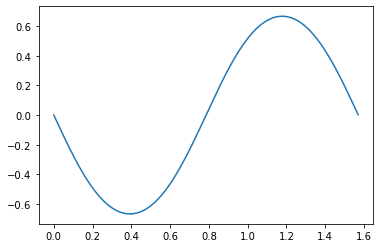

In [17]:
plt.plot(time_arr, total_my_time_old[1])

In [37]:
plt.plot(Bx_arr_old, total_mx_arr_old[0], label="Average Mx")
plt.plot(Bx_arr_old, total_my_arr_old[0], label="Aveage My")
plt.plot(Bx_arr_old, total_mz_arr_old[0], label="Average Mz")
plt.legend(loc="upper right")

plt.xlabel("Bx")
plt.ylabel("Average Mx, My, and Mz")

plt.grid()

/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [16]:
for i in range(len(Bx_arr_old)):
    plt.pause(0.3)
    plt.cla()
    plt.grid()
    plt.plot(time_arr, total_mx_time_old[i], label="Mx(t)")
    plt.plot(time_arr, total_my_time_old[i], label="My(t)")
    plt.plot(time_arr, total_mz_time_old[i], label="Mz(t)")
    plt.legend(loc="upper right")
    plt.title(("Bx: "+str('%.1f'%(Bx_arr_old[i]))+" (OLD ALGORITHM)"))
    plt.show()
    

/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part


In [29]:
result= np.square(total_mx_time_old[10])+np.square(total_my_time_old[10])+np.square(total_mz_time_old[10])
plt.cla()
plt.ylim(-1.1,1.1)
plt.plot(time_arr, result)

/Users/michaelalexander/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [35]:
result= np.square(total_mx_arr[0])+np.square(total_my_arr[0])+np.square(total_mz_arr[0])
plt.cla()
plt.plot(Bx_arr, result, color="orange")
plt.grid()
plt.xlabel("Bx")
plt.ylabel("Magnitude of the average magnetization")
plt.title("The Old Algorithm")
plt.show()

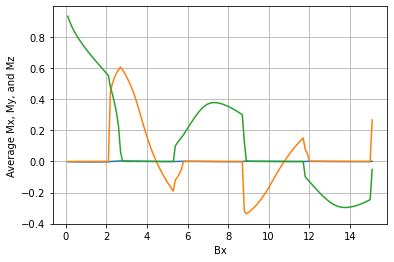

In [18]:
plt.plot(Bx_arr, total_mx_arr[0])
plt.plot(Bx_arr, total_my_arr[0])
plt.plot(Bx_arr, total_mz_arr[0])
plt.legend 
plt.xlabel("Bx")
plt.ylabel("Average Mx, My, and Mz")
plt.grid()

In [27]:
%matplotlib 
plt.plot(Bx_arr_old, np.absolute(total_mz_arr_old[0]), label="Old Algorithm")
plt.plot(Bx_arr, np.absolute(total_mz_arr[0]), label="New Algorithm")
plt.grid()
plt.legend(loc="upper right")
plt.xlabel("Bx")
plt.ylabel("Average Mz")
plt.show()



Using matplotlib backend: MacOSX


### WINDING NUMBER FOR THE OLD ALGORITHM

In [17]:
## Rotational matrices as functions ##
def z_axis_rot(angle, vector):
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                           [np.sin(angle), np.cos(angle), 0],
                           [0, 0, 1]])
    
    new_vector = np.matmul(rot_matrix, vector)
    
    return new_vector;


def x_axis_rot(angle, vector):
    rot_matrix = np.array([[np.cos(angle), 0, np.sin(angle)],
                           [0, 1, 0],
                           [-np.sin(angle), 0, np.cos(angle)]])
    
    new_vector = np.matmul(rot_matrix, vector)
    
    return new_vector;
    
def y_axis_rot(angle, vector):
    rot_matrix = np.array([[1, 0, 0], 
                           [0, np.cos(angle), -np.sin(angle)], 
                           [0, np.sin(angle), np.cos(angle)]])
    
    new_vector = np.matmul(rot_matrix, vector)
    
    return new_vector;


## Indicating which quadrant is the magnetization vector is on (in 2D space) ##
def which_quadrant(x,y):
    quadrant = 0
    if(x>0 and y>0):
        quadrant = 1
        return int(quadrant)
    elif(x<0 and y>0):
        quadrant = 2
        return int(quadrant)
    elif(x<0 and y<0):
        quadrant = 3
        return int(quadrant)
    elif(x>0 and y<0):
        quadrant = 4
        return int(quadrant)

In [43]:
## Projection of the average Mx, My, Mz to a spherical coordinate ##
idx = np.where(Bx_arr_old == 0.5) # Give the index of a specific Bx value (in this case is Bx = 3.1)
idx[0][0] = idx[0][0]

p_radius = np.sqrt(np.square(total_mx_arr_old[0][idx[0][0]])+np.square(total_my_arr_old[0][idx[0][0]])
                   +np.square(total_mz_arr_old[0][idx[0][0]]))

p_theta = np.arctan(total_my_arr_old[0][idx[0][0]]/total_mx_arr_old[0][idx[0][0]])  # z-axis rotation

p_phi = np.arctan(np.sqrt(np.square(total_mx_arr_old[0][idx[0][0]])+np.square(total_my_arr_old[0][idx[0][0]]))
                  /total_mz_arr_old[0][idx[0][0]]) 

## Constructing the magnetization vector ##
M_array = []
for i in range(len(time_arr)):
    M_vector = []
    M_vector.append((total_mx_time_old[idx[0][0]])[i])
    M_vector.append((total_my_time_old[idx[0][0]])[i])
    M_vector.append((total_mz_time_old[idx[0][0]])[i])
    M_array.append(M_vector)

In [44]:
plt.cla()
origin_point = [0,0,0]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
Bx = Bx_arr_old[idx[0][0]]

r = 0.05
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.5)
plt.xlabel("Mx")
plt.ylabel("My")
plt.title(("Bx = "+str(Bx)))
ax.set_zlabel("Mz")

for i in range(len(time_arr)): 

    #plt.pause(0.5)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    ax.set_xlim(-1,1)
    ax.grid()
    ax.scatter3D(M_array[i][0], M_array[i][1],M_array[i][2], color = "green", s=0.5)
    
    plt.show()

In [34]:
theta = np.linspace( 0 , 2 * np.pi , 150 )
radius = 10
 
    
a = radius * np.cos( theta )
b = radius * np.sin( theta )

a = 2*radius*a/(radius-0)
b = 2*radius*b/(radius-0)

 
figure_2d, axes_2d = plt.subplots( 1 )
 
axes_2d.cla()

plt.xlim(-1,1)
plt.ylim(-3,3)

plt.xlabel("Y")
plt.ylabel("Z")

prev_proj_theta = 0;
proj_theta_sum = 0;
proj_theta_arr = []
proj_rad_arr = []

angle_z = 0
angle_x = np.pi/2
angle_y = 0

X_arr = []
Y_arr = []

present_quadrant = 0
prev_quadrant = 0

q4_to_q1 = 0 # when q4_to_q1 = 1, it inidicates that the vector is going from quadrant 4 to quadrant 1



for i in range(len(time_arr)):
    new_vector = z_axis_rot(angle_z, M_array[i])
    new_vector = x_axis_rot(angle_x, new_vector)
    new_vector = y_axis_rot(angle_y, new_vector)

    x = new_vector[0]
    y = new_vector[1]
    z = new_vector[2]
    
    
    X = 2*radius*x/(radius-z)
    Y = 2*radius*y/(radius-z)
    
    
    X_arr.append(X)
    Y_arr.append(Y)
    



for i in range(len(time_arr)):
    
    proj_theta = np.degrees(np.arctan(Y_arr[i].real/X_arr[i].real))
    proj_rad = np.sqrt(X_arr[i]**2+Y_arr[i]**2)
    
    present_quadrant = which_quadrant(X_arr[i], Y_arr[i])
    
    if(present_quadrant != prev_quadrant):
        if(present_quadrant == 1 and prev_quadrant == 4):
            q4_to_q1 += 1
        elif(present_quadrant == 4 and prev_quadrant == 1):
            q4_to_q1 -= 1
        
    if(q4_to_q1 != 0):
        proj_theta = (q4_to_q1*360)+proj_theta
        
    if(Y_arr[i] > 0 and X_arr[i]<0):
        proj_theta = 180+proj_theta
        
    elif(Y_arr[i]<0 and X_arr[i]<0):
        proj_theta = 180+proj_theta
        
    elif(Y_arr[i]<0 and X_arr[i]>0):
        proj_theta = 360+proj_theta
        
    proj_theta_arr.append(proj_theta)
    proj_rad_arr.append(proj_rad)
    
    
    
    if(i==0):
        proj_theta_diff = 0
    else:
        proj_theta_diff = (proj_theta-prev_proj_theta)
        
        
    proj_theta_sum += proj_theta_diff
    print("this is number of windings per time:", proj_theta_sum/360, "This is the theta:",proj_theta)
    print("This is the difference:",proj_theta_diff)
    print()

    prev_proj_theta = proj_theta
    prev_quadrant = present_quadrant
    

    axes_2d.scatter(0,0,color="blue",s=0.5)
    axes_2d.scatter(X_arr[i],Y_arr[i], color = "green", s=0.5)
    #plt.pause(1)

    plt.show()
    

    
n_of_windings = proj_theta_sum/(360)
print(n_of_windings)


this is number of windings per time: 0.0 This is the theta: 0.0
This is the difference: 0

this is number of windings per time: 0.9905004564042511 This is the theta: 356.5801643055304
This is the difference: 356.5801643055304

this is number of windings per time: 0.9810007403894512 This is the theta: 353.16026654020243
This is the difference: -3.41989776532796

this is number of windings per time: 0.9715006819096789 This is the theta: 349.7402454874844
This is the difference: -3.4200210527180275

this is number of windings per time: 0.9620001157718433 This is the theta: 346.32004167786357
This is the difference: -3.42020380962083

this is number of windings per time: 0.9524988843187114 This is the theta: 342.8995983547361
This is the difference: -3.420443323127472

this is number of windings per time: 0.9429968403929817 This is the theta: 339.4788625414734
This is the difference: -3.420735813262695

this is number of windings per time: 0.9334938506330661 This is the theta: 336.05778622

this is number of windings per time: -0.4219957034916883 This is the theta: -151.9184532570078
This is the difference: -2.748940904351855

this is number of windings per time: -0.42960750673792614 This is the theta: -154.65870242565342
This is the difference: -2.7402491686456187

this is number of windings per time: -0.4371951778271902 This is the theta: -157.39026401778847
This is the difference: -2.7315615921350513

this is number of windings per time: -0.44475872754218104 This is the theta: -160.11314191518517
This is the difference: -2.7228778973966996

this is number of windings per time: -0.4522981641957685 This is the theta: -162.82733911047666
This is the difference: -2.71419719529149

this is number of windings per time: -0.45981349237748154 This is the theta: -165.53285725589336
This is the difference: -2.705518145416704

this is number of windings per time: -0.46730471215087227 This is the theta: -168.22969637431402
This is the difference: -2.6968391184206553

this is number

this is number of windings per time: -1.0379546419776655 This is the theta: -373.6636711119596
This is the difference: -1.7702795047866857

this is number of windings per time: -1.0428394945850181 This is the theta: -375.4222180506065
This is the difference: -1.758546938646873

this is number of windings per time: -1.0476916168947688 This is the theta: -377.1689820821167
This is the difference: -1.7467640315102244

this is number of windings per time: -1.0525108761149602 This is the theta: -378.9039154013857
This is the difference: -1.7349333192689755

this is number of windings per time: -1.0572971480610827 This is the theta: -380.6269733019898
This is the difference: -1.7230579006040898

this is number of windings per time: -1.0620503184988492 This is the theta: -382.3381146595857
This is the difference: -1.7111413575959205

this is number of windings per time: -1.0667702842461795 This is the theta: -384.0373023286246
This is the difference: -1.6991876690389063

this is number of win

this is number of windings per time: -1.376699430720462 This is the theta: -495.6117950593664
This is the difference: -0.16437919544785018

this is number of windings per time: -1.3771185362997664 This is the theta: -495.7626730679159
This is the difference: -0.15087800854951183

this is number of windings per time: -1.3775001562481568 This is the theta: -495.90005624933644
This is the difference: -0.13738318142054595

this is number of windings per time: -1.3778443071755422 This is the theta: -496.0239505831952
This is the difference: -0.12389433385874327

this is number of windings per time: -1.37815100449532 This is the theta: -496.1343616183152
This is the difference: -0.11041103512002337

this is number of windings per time: -1.378420262294879 This is the theta: -496.2312944261564
This is the difference: -0.09693280784119906

this is number of windings per time: -1.3786520932179052 This is the theta: -496.3147535584459
This is the difference: -0.08345913228947666

this is number o

this is number of windings per time: -1.2294080363106485 This is the theta: -442.5868930718335
This is the difference: 1.1956350692731803

this is number of windings per time: -1.2260514560833498 This is the theta: -441.3785241900059
This is the difference: 1.208368881827596

this is number of windings per time: -1.2226596586781635 This is the theta: -440.15747712413884
This is the difference: 1.221047065867083

this is number of windings per time: -1.21923279905374 This is the theta: -438.9238076593464
This is the difference: 1.233669464792456

this is number of windings per time: -1.2157710314896024 This is the theta: -437.67757133625685
This is the difference: 1.2462363230895335

this is number of windings per time: -1.212274508441291 This is the theta: -436.41882303886473
This is the difference: 1.258748297392117

this is number of windings per time: -1.2087433793816078 This is the theta: -435.1476165773788
This is the difference: 1.2712064614859173

this is number of windings per 

this is number of windings per time: -0.5796015551046778 This is the theta: -208.65655983768403
This is the difference: 2.5538129666955456

this is number of windings per time: -0.5724833629105744 This is the theta: -206.09401064780678
This is the difference: 2.5625491898772452

this is number of windings per time: -0.5653408894575768 This is the theta: -203.52272020472765
This is the difference: 2.5712904430791355

this is number of windings per time: -0.5581741246413869 This is the theta: -200.9426848708993
This is the difference: 2.5800353338283344

this is number of windings per time: -0.5509830630505772 This is the theta: -198.35390269820778
This is the difference: 2.5887821726915377

this is number of windings per time: -0.5437677044275249 This is the theta: -195.75637359390896
This is the difference: 2.5975291042988147

this is number of windings per time: -0.5365280537706466 This is the theta: -193.1500993574328
This is the difference: 2.6062742364761675

this is number of wind

This is the difference: 3.2872012630730865

this is number of windings per time: 0.32020178463790894 This is the theta: 115.27264246964721
This is the difference: 3.290376894102195

this is number of windings per time: 0.3293501400644545 This is the theta: 118.56605042320362
This is the difference: 3.293407953556411

this is number of windings per time: 0.3385065612976801 This is the theta: 121.86236206716484
This is the difference: 3.296311643961218

this is number of windings per time: 0.3476707447491377 This is the theta: 125.16146810968957
This is the difference: 3.299106042524727

this is number of windings per time: 0.35684243805262156 This is the theta: 128.46327769894376
This is the difference: 3.3018095892541908

this is number of windings per time: 0.3660214397064116 This is the theta: 131.76771829430817
This is the difference: 3.3044405953644116

this is number of windings per time: 0.37520759745965315 This is the theta: 135.07473508547514
This is the difference: 3.307016791

this is number of windings per time: 1.4039989272262987 This is the theta: 505.43961380146754
This is the difference: 3.3771826766859476

this is number of windings per time: 1.4133710394070442 This is the theta: 508.8135741865359
This is the difference: 3.373960385068358

this is number of windings per time: 1.422734239073903 This is the theta: 512.1843260666051
This is the difference: 3.3707518800691787

this is number of windings per time: 1.432088584214908 This is the theta: 515.5518903173669
This is the difference: 3.367564250761802

this is number of windings per time: 1.4414341485621498 This is the theta: 518.9162934823739
This is the difference: 3.3644031650070474

this is number of windings per time: 1.4507710181375735 This is the theta: 522.2775665295264
This is the difference: 3.3612730471525083

this is number of windings per time: 1.4600992883578399 This is the theta: 525.6357438088223
This is the difference: 3.3581772792958873

this is number of windings per time: 1.46941

this is number of windings per time: 2.403642959063708 This is the theta: 865.3114652629349
This is the difference: 2.7697972478417796

this is number of windings per time: 2.4113126792106034 This is the theta: 868.0725645158172
This is the difference: 2.7610992528823317

this is number of windings per time: 2.4189582423041105 This is the theta: 870.8249672294799
This is the difference: 2.7524027136626046

this is number of windings per time: 2.4265796573314877 This is the theta: 873.5686766393356
This is the difference: 2.7437094098557964

this is number of windings per time: 2.4341769355847256 This is the theta: 876.3036968105013
This is the difference: 2.7350201711656155

this is number of windings per time: 2.4417500883812537 This is the theta: 879.0300318172514
This is the difference: 2.726335006750105

this is number of windings per time: 2.4492991251927223 This is the theta: 881.74768506938
This is the difference: 2.7176532521286845

this is number of windings per time: 2.456824

this is number of windings per time: 3.267477897053721 This is the theta: 1176.2920429393396
This is the difference: 1.0495650299978934

this is number of windings per time: 3.2703564554778857 This is the theta: 1177.3283239720388
This is the difference: 1.0362810326992076

this is number of windings per time: 3.273198033254271 This is the theta: 1178.3512919715376
This is the difference: 1.02296799949886

this is number of windings per time: 3.2760025570054885 This is the theta: 1179.360920521976
This is the difference: 1.009628550438265

this is number of windings per time: 3.2787699604024056 This is the theta: 1180.357185744866
This is the difference: 0.9962652228900879

this is number of windings per time: 3.281500183866976 This is the theta: 1181.3400661921114
This is the difference: 0.9828804472454067

this is number of windings per time: 3.284193174216817 This is the theta: 1182.3095427180542
This is the difference: 0.9694765259428095

this is number of windings per time: 3.2868

This is the difference: -0.4521831634338014

this is number of windings per time: 3.3564043121321205 This is the theta: 1208.3055523675635
This is the difference: -0.46580072037295395

this is number of windings per time: 3.355072595762127 This is the theta: 1207.8261344743657
This is the difference: -0.4794178931977058

this is number of windings per time: 3.35370305673466 This is the theta: 1207.3331004244776
This is the difference: -0.4930340498881378

this is number of windings per time: 3.3522956995587867 This is the theta: 1206.8264518411631
This is the difference: -0.5066485833144725

this is number of windings per time: 3.3508505303411917 This is the theta: 1206.306190922829
This is the difference: -0.5202609183340883

this is number of windings per time: 3.3493675566789283 This is the theta: 1205.7723204044141
This is the difference: -0.5338705184149148

this is number of windings per time: 3.347846787535439 This is the theta: 1205.224843512758
This is the difference: -0.54747

this is number of windings per time: 2.937979355492424 This is the theta: 1057.6725679772726
This is the difference: -1.9764499396219435

this is number of windings per time: 2.9324581150944553 This is the theta: 1055.6849214340039
This is the difference: -1.9876465432687382

this is number of windings per time: 2.9269057067551305 This is the theta: 1053.686054431847
This is the difference: -1.998867002156885

this is number of windings per time: 2.9213220529175254 This is the theta: 1051.6759390503091
This is the difference: -2.010115381537844

this is number of windings per time: 2.9157070670414384 This is the theta: 1049.6545441349178
This is the difference: -2.0213949153912836

this is number of windings per time: 2.910060656190678 This is the theta: 1047.621836228644
This is the difference: -2.0327079062737994

this is number of windings per time: 2.9043827238568687 This is the theta: 1045.5777805884727
This is the difference: -2.0440556401713366

this is number of windings per ti

this is number of windings per time: 2.0295433767931548 This is the theta: 730.6356156455357
This is the difference: -3.0816393678126133

this is number of windings per time: 2.020967580185277 This is the theta: 727.5483288666996
This is the difference: -3.0872867788360736

this is number of windings per time: 2.0123760923677696 This is the theta: 724.455393252397
This is the difference: -3.0929356143026325

this is number of windings per time: 2.003768904859116 This is the theta: 721.3568057492818
This is the difference: -3.0985875031152545

this is number of windings per time: 1.995146003151997 This is the theta: 718.2525611347189
This is the difference: -3.1042446145628446

this is number of windings per time: 1.986507365168484 This is the theta: 715.1426514606542
This is the difference: -3.1099096740647383

this is number of windings per time: 1.9778529598344954 This is the theta: 712.0270655404183
This is the difference: -3.1155859202358442

this is number of windings per time: 1.

## Finding the winding number from all of the Bx values

In [47]:
winding_number = []
for j in range(len(Bx_arr_old)):
    
    M_array = []
    for i in range(len(time_arr)):
        M_vector = []
        M_vector.append((total_mx_time_old[j])[i])
        M_vector.append((total_my_time_old[j])[i])
        M_vector.append((total_mz_time_old[j])[i])
        M_array.append(M_vector)
    
    theta = np.linspace( 0 , 2 * np.pi , 150 )
    radius = 10


    a = radius * np.cos( theta )
    b = radius * np.sin( theta )

    a = 2*radius*a/(radius-0)
    b = 2*radius*b/(radius-0)






    plt.xlim(-1,1)
    plt.ylim(-3,3)

    plt.xlabel("Y")
    plt.ylabel("Z")

    prev_proj_theta = 0;
    proj_theta_sum = 0;
    proj_theta_arr = []
    proj_rad_arr = []

    angle_z = 0
    angle_x = 0
    angle_y = 0

    X_arr = []
    Y_arr = []

    present_quadrant = 0
    prev_quadrant = 0

    q4_to_q1 = 0 # when q4_to_q1 = 1, it inidicates that the vector is going from quadrant 4 to quadrant 1



    for i in range(len(time_arr)):
        new_vector = z_axis_rot(angle_z, M_array[i])
        new_vector = x_axis_rot(angle_x, new_vector)
        new_vector = y_axis_rot(angle_y, new_vector)

        x = new_vector[0]
        y = new_vector[1]
        z = new_vector[2]


        X = 2*radius*x/(radius-z)
        Y = 2*radius*y/(radius-z)


        X_arr.append(X)
        Y_arr.append(Y)




    for i in range(len(time_arr)):

        proj_theta = np.degrees(np.arctan(Y_arr[i].real/X_arr[i].real))
        proj_rad = np.sqrt(X_arr[i]**2+Y_arr[i]**2)

        present_quadrant = which_quadrant(X_arr[i], Y_arr[i])

        if(present_quadrant != prev_quadrant):
            if(present_quadrant == 1 and prev_quadrant == 4):
                q4_to_q1 += 1
            elif(present_quadrant == 4 and prev_quadrant == 1):
                q4_to_q1 -= 1

        if(q4_to_q1 != 0):
            proj_theta = (q4_to_q1*360)+proj_theta

        if(Y_arr[i] > 0 and X_arr[i]<0):
            proj_theta = 180+proj_theta

        elif(Y_arr[i]<0 and X_arr[i]<0):
            proj_theta = 180+proj_theta

        elif(Y_arr[i]<0 and X_arr[i]>0):
            proj_theta = 360+proj_theta

        proj_theta_arr.append(proj_theta)
        proj_rad_arr.append(proj_rad)



        if(i==0):
            proj_theta_diff = 0
        else:
            proj_theta_diff = (proj_theta-prev_proj_theta)


        proj_theta_sum += proj_theta_diff
#         print("this is number of windings per time:", proj_theta_sum/360, "This is the theta:",proj_theta)
#         print("This is the difference:",proj_theta_diff)
#         print()

        prev_proj_theta = proj_theta
        prev_quadrant = present_quadrant


        #plt.pause(1)





    n_of_windings = proj_theta_sum/(360)
    winding_number.append(n_of_windings)
    print("Bx:", Bx_arr_old[j], "; Winding Number", n_of_windings)

Bx: 0.1 ; Winding Number 1.4994282617399777
Bx: 0.2 ; Winding Number 1.4993780766115934
Bx: 0.30000000000000004 ; Winding Number 1.4993264419216308
Bx: 0.4 ; Winding Number 1.4992706589757097
Bx: 0.5 ; Winding Number 1.4992085578099064
Bx: 0.6 ; Winding Number 1.4991372063749038
Bx: 0.7000000000000001 ; Winding Number 1.499057011742296
Bx: 0.8 ; Winding Number 1.4989642835883374
Bx: 0.9 ; Winding Number 1.4988560634420511
Bx: 1.0 ; Winding Number 1.4987279492226946
Bx: 1.1 ; Winding Number 1.4985743286372313
Bx: 1.2000000000000002 ; Winding Number 1.4983869741101283
Bx: 1.3000000000000003 ; Winding Number 1.4981546759101942
Bx: 1.4000000000000001 ; Winding Number 1.49785961320026
Bx: 1.5000000000000002 ; Winding Number 1.497473893154021
Bx: 1.6 ; Winding Number 1.496954823297645
Bx: 1.7000000000000002 ; Winding Number 1.4962128344294217
Bx: 1.8000000000000003 ; Winding Number 1.4950809682519206
Bx: 1.9000000000000001 ; Winding Number 1.4931636330500586
Bx: 2.0 ; Winding Number 1.489278

Bx: 17.500000000000004 ; Winding Number -0.6432254261769589
Bx: 17.6 ; Winding Number -0.6811064085761344
Bx: 17.700000000000003 ; Winding Number -0.7274977545849678
Bx: 17.8 ; Winding Number -1.7789525739623262
Bx: 17.900000000000002 ; Winding Number 2.177258555342052
Bx: 18.000000000000004 ; Winding Number 2.145041078974745


In [48]:
plt.plot(Bx_arr_old, winding_number)
